In [2]:
# read IGES file
filename = '../data/FEM/FEM2.vtu'
outname  = '../data/FEM/FEM2_solved.vtk'

In [3]:
import numpy as np
import pyvista as pv
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from matplotlib import pyplot as plt

young = 20e9
poisson = 0.3

mesh = pv.read(filename)
points = mesh.points
tetras = mesh.cells.reshape(-1, 5)[:, 1:]

femesh = MeshTet(points.T, tetras.T)

e1 = ElementTetP1()
e = ElementVector(e1)
ib = Basis(femesh, e, MappingIsoparametric(femesh, e1), 3)

K = asm(linear_elasticity(*lame_parameters(young, poisson)), ib)

deg_xy = lambda x: np.rad2deg(np.arctan2(x[0], x[1]))

dofs = {
    'left' : ib.get_dofs(lambda x: deg_xy(x) < -29.99),
    'right' : ib.get_dofs(lambda x: deg_xy(x) > 29.99),
}

u = ib.zeros()
u[dofs['left'].nodal['u^1']] = -1e-4
u[dofs['right'].nodal['u^1']] = 1e-4

print_udofs = lambda key: print(key, dofs[key].nodal['u^1'].shape)

print_udofs('left')
print_udofs('right')

I = ib.complement_dofs(dofs)

u = solve(*condense(K, x=u, I=I))

sf = 1.0
femesh = femesh.translated(sf * u[ib.nodal_dofs])

print('Writing to', outname)
femesh.save(outname)


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


left (251,)
right (236,)
Writing to ../data/FEM/FEM2_solved.vtk


In [4]:
V = points
dV = u.reshape(-1, 3)
T = femesh.t.T

V.shape, dV.shape, T.shape

((9086, 3), (9086, 3), (46366, 4))

In [5]:
(V + dV)[:4]  - femesh.p.T[:4]

pyvista_ndarray([[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]])

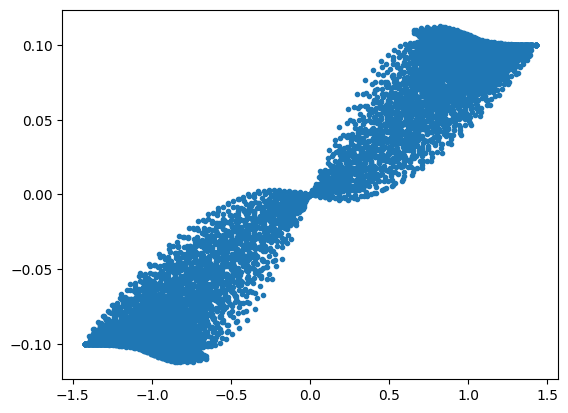

In [6]:
plt.plot(V[:, 0]*1e3, dV[:, 0]*1e3, '.')

## ミーゼス応力の計算

In [7]:
V = V * 1e3
dV = dV * 1e3


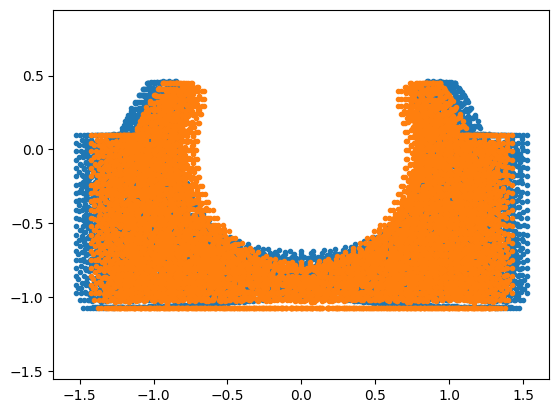

In [8]:
plt.plot(V.T[0] + dV.T[0], V.T[2] + dV.T[2], '.')
plt.plot(V.T[0], V.T[2], '.')

plt.axis('equal')
plt.show()


In [11]:
tetra_coords = lambda v: (v[1:] - v[0]).T

E = np.zeros((T.shape[0], 3, 3))
F = np.zeros((T.shape[0], 3, 3))

for t, i in zip(T, range(T.shape[0])):
    
    # 初期と変位後の座標を計算
    X = tetra_coords(V[t])
    Y = tetra_coords(V[t] + dV[t])
    
    # 変形勾配テンソルFを計算
    F[i] = np.linalg.solve(X.T, Y.T).T
    
    # 右ひずみテンソルEを計算
    E[i] = 0.5 * (F[i].T @ F[i] - np.eye(3))


In [12]:
F[10000], E[10000]

(array([[ 1.01351726, -0.04799237,  0.00888215],
        [ 0.05810079,  0.98647739,  0.0023092 ],
        [-0.02062333,  0.00336636,  1.00006686]]),
 array([[ 0.01550913,  0.0043023 , -0.00574417],
        [ 0.0043023 , -0.01227388,  0.00260914],
        [-0.00574417,  0.00260914,  0.00010897]]))

In [13]:
# 右Cauchy-Greenひずみテンソル
C = np.einsum('...ij,...jk->...ik', F, F.transpose((0,2,1)))  # (m, 3, 3)

# Green-Lagrangeひずみテンソル
E = 0.5*(C - np.eye(3))  # (m, 3, 3)

lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
mu = young / (2 * (1 + poisson))

I = np.eye(3)  # 単位行列
sigma = np.empty_like(E)  # Initialize stress tensor array
for i in range(E.shape[0]):
    eps = E[i]
    sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps

In [15]:
# ボン・ミーゼス応力を計算
sigma_xx, sigma_yy, sigma_zz = sigma[:, 0, 0], sigma[:, 1, 1], sigma[:, 2, 2]
sigma_xy, sigma_yz, sigma_zx = sigma[:, 0, 1], sigma[:, 1, 2], sigma[:, 2, 0]

sigma_vm = np.sqrt(((sigma_xx - sigma_yy)**2 * 0.5 + 
                    (sigma_yy - sigma_zz)**2 * 0.5 + 
                    (sigma_zz - sigma_xx)**2 * 0.5 + 
                    (sigma_xy**2 + sigma_yz**2 + sigma_zx**2) * 3.0))  # (m,)

sigma_vm.shape

(46366,)

In [17]:
i = 10000
F[i], C[i], E[i], sigma[i], sigma_vm[i], F[i] - np.eye(3), C[i] - np.eye(3),

(array([[ 1.01351726, -0.04799237,  0.00888215],
        [ 0.05810079,  0.98647739,  0.0023092 ],
        [-0.02062333,  0.00336636,  1.00006686]]),
 array([[ 1.02959939,  0.01156328, -0.01218092],
        [ 0.01156328,  0.97651868,  0.00443196],
        [-0.01218092,  0.00443196,  1.00057037]]),
 array([[ 0.0147997 ,  0.00578164, -0.00609046],
        [ 0.00578164, -0.01174066,  0.00221598],
        [-0.00609046,  0.00221598,  0.00028519]]),
 array([[ 2.66274798e+08,  8.89482727e+07, -9.36994110e+07],
        [ 8.89482727e+07, -1.42038371e+08,  3.40920042e+07],
        [-9.36994110e+07,  3.40920042e+07,  4.29746721e+07]]),
 423045065.123206,
 array([[ 1.35172570e-02, -4.79923740e-02,  8.88214526e-03],
        [ 5.81007934e-02, -1.35226084e-02,  2.30920186e-03],
        [-2.06233321e-02,  3.36635819e-03,  6.68578663e-05]]),
 array([[ 0.02959939,  0.01156328, -0.01218092],
        [ 0.01156328, -0.02348132,  0.00443196],
        [-0.01218092,  0.00443196,  0.00057037]]))

In [18]:
# Create a PyVista mesh object from the tetrahedral mesh
mesh = pv.read(outname)

# Add the displacement and von Mises stress as point data
mesh.cell_data['von_mises_stress'] = sigma_vm

mesh.cell_data['F'] = F[:,0,0]
mesh.cell_data['C'] = C[:,0,0]
mesh.cell_data['E'] = E[:,0,0]
mesh.cell_data['sigma'] = sigma.T[0,0]

# Write the mesh to a VTK file
print('Rewriting to', outname)
mesh.save(outname)

Rewriting to ../data/FEM/FEM2_solved.vtk


In [15]:
import numpy as np

def compute_strain(V, dV, T):
    strain_tensors = []
    for t in T:
        # 頂点座標と変位を取得
        V_t = V[t]
        dV_t = dV[t]
        
        # 初期と変位後の座標を計算
        X = V_t[1:] - V_t[0]
        Y = (V_t + dV_t)[1:] - (V_t + dV_t)[0]

        # 変形勾配テンソルFを計算
        F = np.linalg.solve(X, Y)

        # 右ひずみテンソルEを計算
        E = 0.5 * (F.T @ F - np.eye(3))

        strain_tensors.append(E)

    return np.array(strain_tensors)

E = compute_strain(V, dV, T)
E[0]

array([[ 0.00609941, -0.00025209, -0.000402  ],
       [-0.00025209,  0.00440646, -0.00276089],
       [-0.000402  , -0.00276089,  0.00178306]])

In [16]:
lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
mu = young / (2 * (1 + poisson))

I = np.eye(3)  # 単位行列
sigma = np.empty_like(E)  # Initialize stress tensor array
for i in range(E.shape[0]):
    eps = E[i]
    sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps
    